In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import osmnx as ox
import networkx as nx
import random
import tqdm
import torch.nn.functional as F
import numpy as np

In [2]:
def load_map():
    return ox.graph_from_place("Lviv Oblast, Ukraine", network_type='drive')

def preprocess_graph(G):
    nodes, edges = ox.graph_to_gdfs(G)
    node_ids = list(G.nodes)
    node_map = {node_id: i for i, node_id in enumerate(node_ids)}
    return G, node_ids, node_map

def heuristic(node, end):
    if nx.has_path(G, node, end):
        return nx.shortest_path_length(G, node, end)
    return float("inf")

class RouteLSTM(nn.Module):
    def __init__(self, num_nodes, hidden_size, embedding_dim=64):
        super(RouteLSTM, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, embedding_dim)
        self.out = nn.Linear(embedding_dim, num_nodes)

    def forward(self, x, hidden, valid_candidates):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        valid_embeddings = self.embedding(valid_candidates)
        similarities = torch.matmul(out, valid_embeddings.T)
        return torch.log_softmax(similarities, dim=-1), hidden

def train_model(model, G, node_ids, node_map, epochs=100):
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    criterion = nn.CrossEntropyLoss()

    connected_nodes = max(nx.strongly_connected_components(G), key=len)  
    node_ids = list(connected_nodes)

    for epoch in tqdm.tqdm(range(epochs), desc='Training Progress'):
        total_loss = 0
        with tqdm.tqdm(range(50), desc=f'Epoch {epoch+1} Loss: 0.0000', leave=False) as pbar:
            for _ in pbar:
                start_node = random.choice(node_ids)
                neighbors = list(G.neighbors(start_node))
                if not neighbors:
                    continue
                valid_targets = [n for n in neighbors if nx.has_path(G, start_node, n)]
                if not valid_targets:
                    continue
                target_node = min(valid_targets, key=lambda n: heuristic(n, start_node))
                input_tensor = torch.tensor([node_map[start_node]], dtype=torch.long).unsqueeze(0)
                target_tensor = torch.tensor([node_map[target_node]], dtype=torch.long)
                optimizer.zero_grad()
                hidden = (torch.zeros(1, 1, 64), torch.zeros(1, 1, 64))
                valid_candidates = torch.tensor([node_map[n] for n in neighbors], dtype=torch.long)
                output, hidden = model(input_tensor, hidden, valid_candidates)
                target_idx = (valid_candidates == target_tensor.item()).nonzero(as_tuple=True)[0]
                if target_idx.numel() == 0:
                    continue
                loss = criterion(output, target_idx)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_description(f'Epoch {epoch+1} Loss: {total_loss / (pbar.n+1):.4f}')
        scheduler.step()
        print(f"Epoch {epoch+1}, Total Loss: {total_loss:.4f}")
    torch.save(model.state_dict(), "route_lstm_current.pth")
    print("Model saved!")

def generate_route(model, G, start, end, node_map, node_ids, resets=0):
    model.eval()
    current_node = start
    visited = set()
    route = [current_node]
    hidden = (torch.zeros(1, 1, 64), torch.zeros(1, 1, 64))
    
    while current_node != end:
        visited.add(current_node)
        neighbors = [n for n in G.neighbors(current_node) if n not in visited]
        if not neighbors:
            if len(route) > 1:
                route.pop()
                current_node = route[-1]
                continue
            else:
                return []
        input_tensor = torch.tensor([node_map[current_node]], dtype=torch.long).unsqueeze(0)
        valid_candidates = torch.tensor([node_map[n] for n in neighbors], dtype=torch.long)
        output, hidden = model(input_tensor, hidden, valid_candidates)
        predicted_indices = torch.argsort(output, descending=True).squeeze().tolist()
        
        next_node = min(neighbors, key=lambda n: heuristic(n, end))
        
        if next_node is None:
            if len(route) > 1:
                route.pop()
                current_node = route[-1]
                continue
            else:
                return []
        
        route.append(next_node)
        current_node = next_node
        
        if len(route) > 2 * nx.shortest_path_length(G, start, end):
            resets += 1
            return generate_route(model, G, start, end, node_map, node_ids, resets)
    
    return route

In [3]:
G = load_map()
G, node_ids, node_map = preprocess_graph(G)

In [4]:
model = RouteLSTM(num_nodes=len(node_ids), hidden_size=64)

In [5]:
#train_model(model, G, node_ids, node_map)

In [6]:
model.load_state_dict(torch.load("route_lstm_current.pth"))
model.eval()

RouteLSTM(
  (embedding): Embedding(54436, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=54436, bias=True)
)

In [13]:
start_node = ox.distance.nearest_nodes(G, 23.979556, 49.806112)
end_node = ox.distance.nearest_nodes(G, 24.032530, 49.839253)

In [14]:
import time
resets = 0
timer_start = time.time()

route = generate_route(model, G, start_node, end_node, node_map, node_ids, resets)

timer_end = time.time()
time_total = timer_end - timer_start
print("time to generate route: " + str(time_total) + " s")

time to generate route: 0.09459185600280762 s


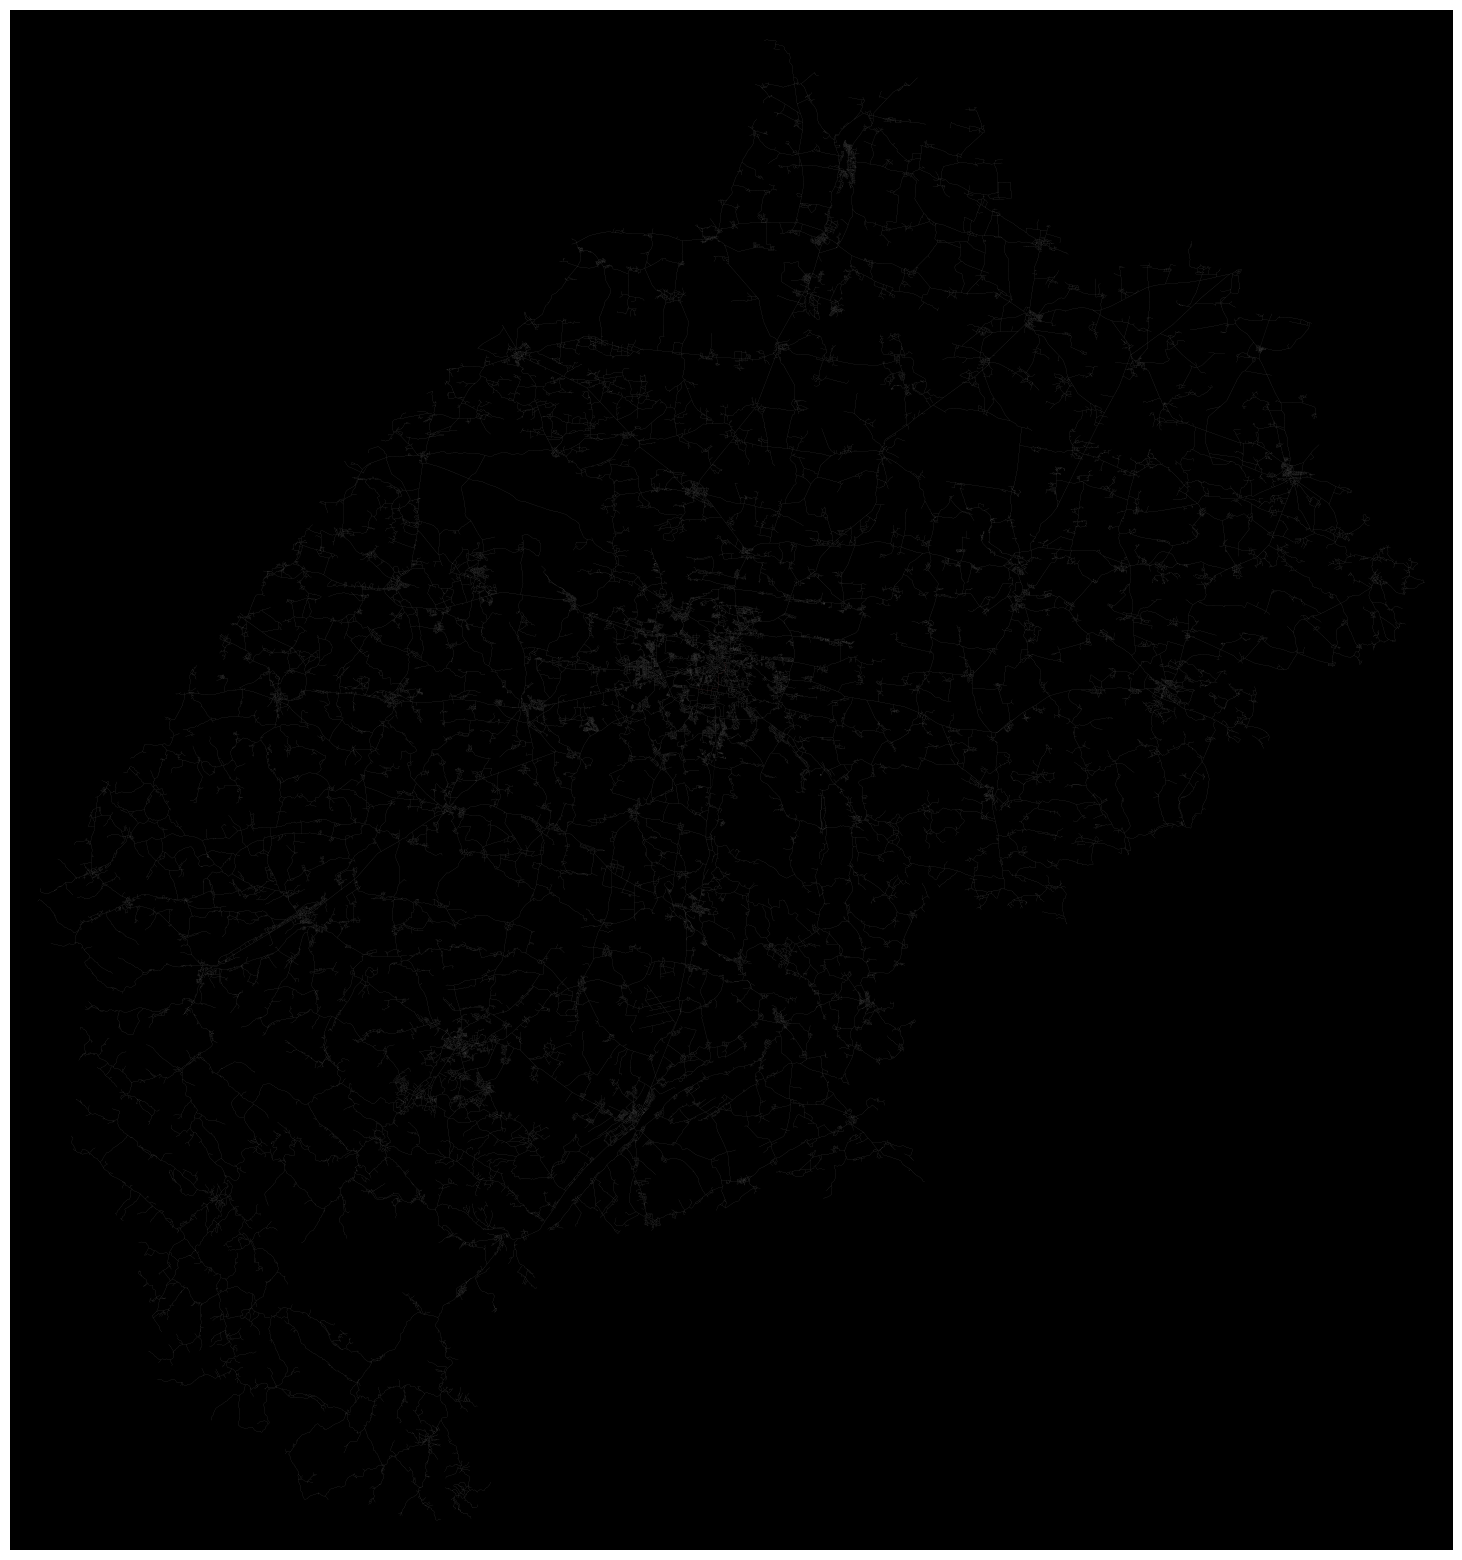

In [15]:
import matplotlib.pyplot as plt
fig, ax = ox.plot_graph_route(
    G, 
    route,
    figsize=(20, 20), 
    node_size=0,
    edge_linewidth=0.02,
    bgcolor='black',
    edge_color="white",
    route_linewidth=0.02,
    route_alpha=1, 
    orig_dest_size=0.03
)

In [10]:
#fig.savefig('TEST_LSTM.png', format='png', dpi=2000, bbox_inches='tight')

In [7]:
import random
map_points=[(49.80611220996008, 23.97955612862654),
(49.80532285209437, 23.98237781261442),
(49.80478275771747, 23.987291619711186),
(49.8042495817099, 23.99243073217024),
(49.80390336037501, 23.996432588052162),
(49.80395183150313, 23.999769256034998),
(49.80649303590949, 23.999114796958104),
(49.81293216592172, 24.000763128745433),
(49.81766865049101, 24.003570346218133),
(49.823736810282, 24.00771312858426),
(49.82582162024907, 24.00966317414233),
(49.832640701340466, 24.01859487887445),
(49.83680583050842, 24.02202637853643),
(49.840145382636926, 24.027186953530506),
(49.84012073274527, 24.028125056144603),
(49.839253501750214, 24.03253064738627)]


def route_creator(destinations):
    random_long_route=[]
    for i in range(destinations):
        coordinate_number = random.randrange(0, len(map_points))
        destination = map_points[coordinate_number]
        random_long_route.append(destination)
    return random_long_route

In [8]:
import time

def generate_multi_stop_route(model, G, waypoints, node_map, node_ids):
    total_route = []
    start_time = time.time()
    resets = 0
    
    for i in range(len(waypoints) - 1):
        start_node = ox.distance.nearest_nodes(G, waypoints[i][1], waypoints[i][0])
        end_node = ox.distance.nearest_nodes(G, waypoints[i + 1][1], waypoints[i + 1][0])
        
        route_segment = generate_route(model, G, start_node, end_node, node_map, node_ids, resets)
        
        if not route_segment:
            return [], 0, 0
        
        if total_route and route_segment[0] == total_route[-1]:
            route_segment = route_segment[1:]
        
        total_route.extend(route_segment)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return elapsed_time, total_route

stops = [2,4,8,16,64]
for i in range(len(stops)):
    target_route = route_creator(stops[i])
    print(len(target_route))
    time_taken, total_route = generate_multi_stop_route(model, G, target_route, node_map, node_ids)
    print("time to generate route: " + str(time_taken) + " s")

2
time to generate route: 0.5683631896972656 s
4
time to generate route: 1.7511637210845947 s
8
time to generate route: 3.6595637798309326 s
16
time to generate route: 8.377260684967041 s
64
time to generate route: 35.094894886016846 s


In [18]:
import time
resets = 0
target_route = route_creator(8)
timer_start = time.time()

time_taken, total_route = generate_multi_stop_route(model, G, target_route, node_map, node_ids)

timer_end = time.time()
time_total = timer_end - timer_start
print("time to generate route: " + str(time_total) + " s")

time to generate route: 4.010015249252319 s


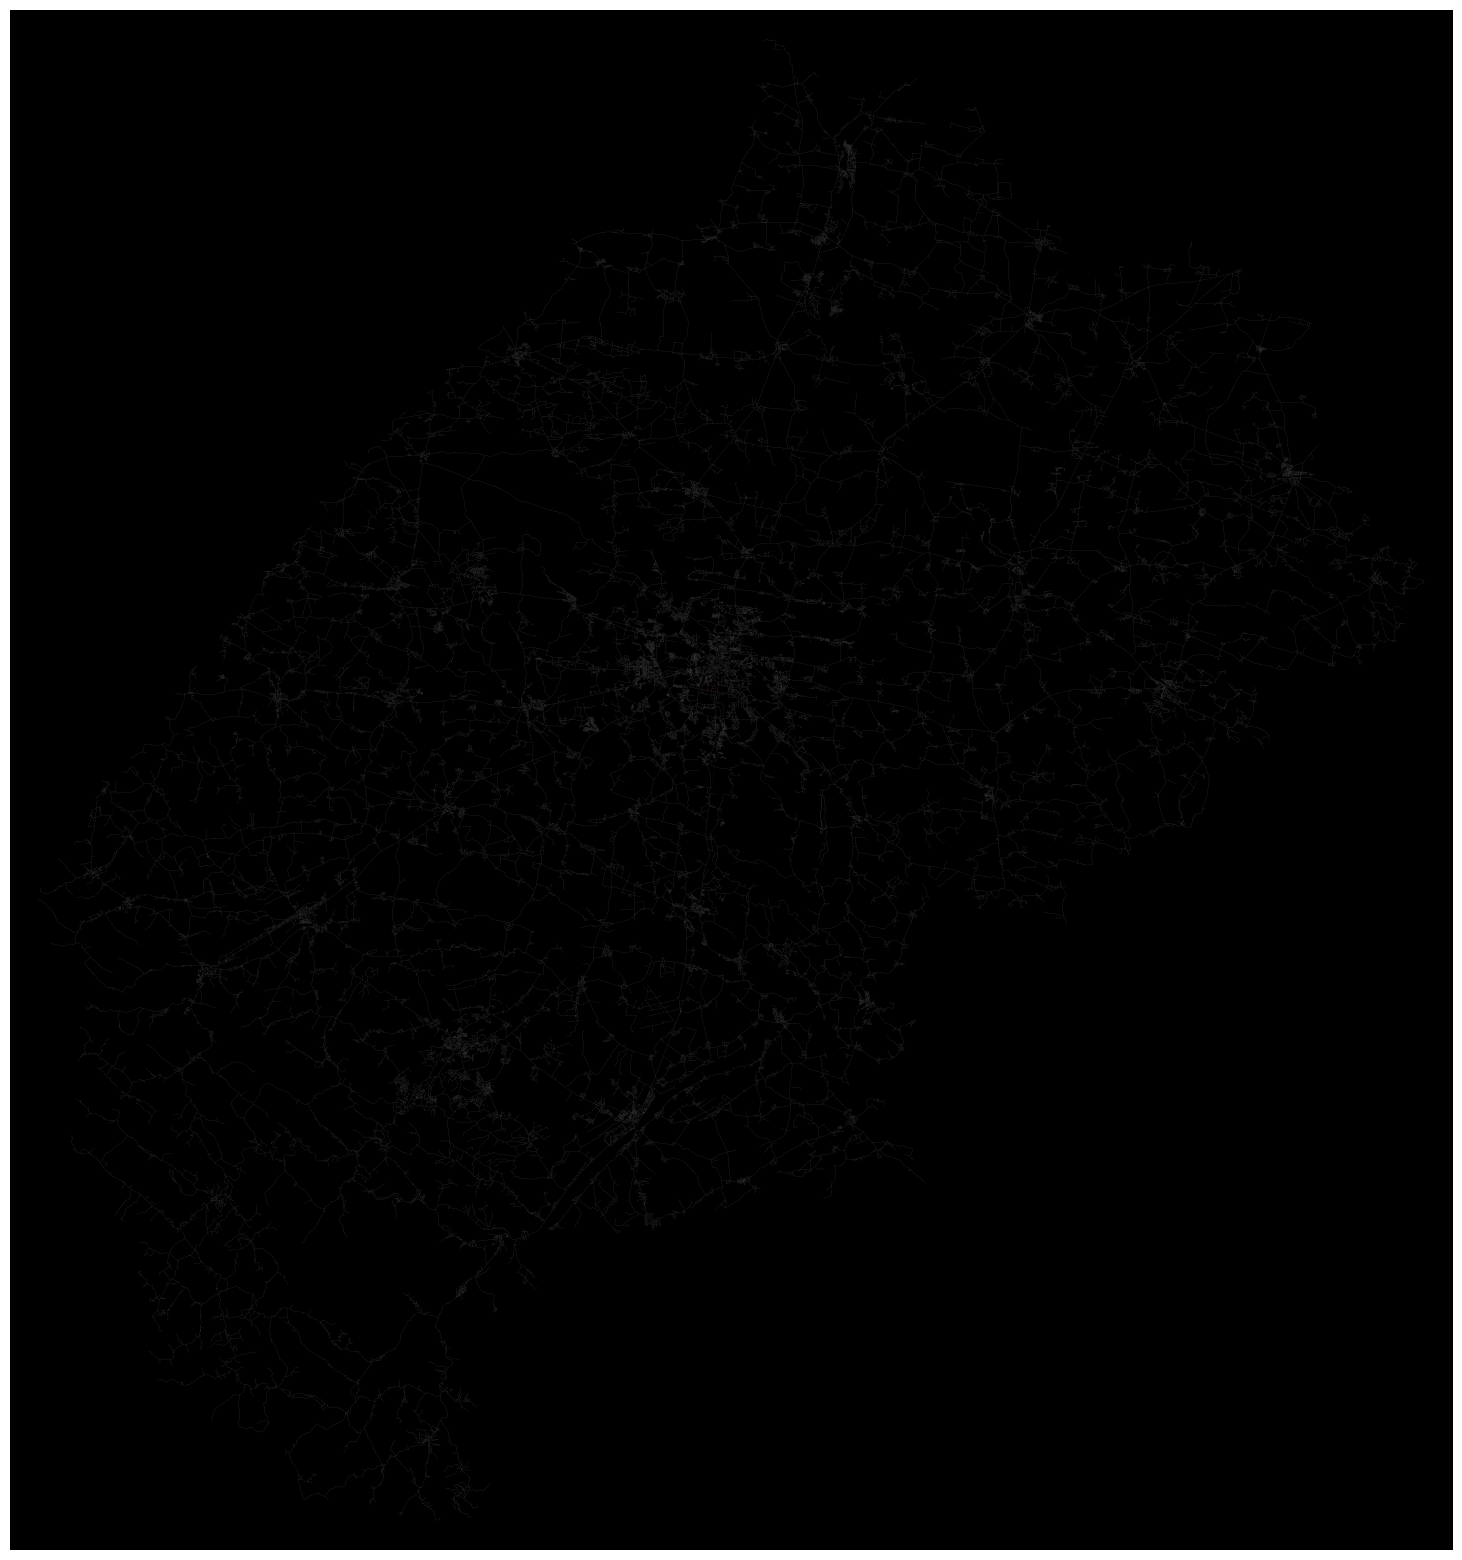

In [20]:
if total_route:
    fig_comp, ax = ox.plot_graph_route(
        G, total_route,
        figsize=(20, 20),
        node_size=0,
        edge_linewidth=0.02,
        bgcolor='black',
        edge_color="white",
        route_linewidth=0.02,
        route_alpha=1,
        orig_dest_size=0.03
    )

In [38]:
#fig_comp.savefig('Complex_route_LSTM.png', format='png', dpi=2000, bbox_inches='tight')